In [ ]:
# Run this cell to install necessary packages
!uv pip install -qU langchain\
    langchain-google-genai langchain-openai\
    langchain-huggingface langchain-community\
    langgraph duckduckgo-search beautifulsoup4

!uv pip install -U huggingface_hub
!uv pip install -U ddgs
!uv pip install -qU pytrends pandas

Using Python 3.12.12 environment at: /usr
Resolved 17 packages in 168ms
Prepared 2 packages in 171ms
Uninstalled 2 packages in 27ms
Installed 2 packages in 26ms
 - huggingface-hub==0.36.0
 + huggingface-hub==1.2.3
 - typer-slim==0.20.0
 + typer-slim==0.20.1
Using Python 3.12.12 environment at: /usr
Resolved 17 packages in 130ms
Prepared 3 packages in 31ms
Installed 3 packages in 15ms
 + ddgs==9.10.0
 + fake-useragent==2.2.0
 + socksio==1.0.0


In [ ]:
import os
import logging
import getpass
from google.colab import userdata


# Setup Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# --- API KEY SETUP ---
# Enter your keys here or ensure they are in your environment variables

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter Google API Key: ")

if "HUGGINGFACEHUB_API_TOKEN" not in os.environ:
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get("HF_IP_KEY")

if "OPENROUTER_API_KEY" not in os.environ:
    os.environ["OPENROUTER_API_KEY"] = getpass.getpass("Enter OpenRouter API Key: ")

logger.info("Environment setup complete.")

Enter Google API Key: ··········


In [ ]:
## types.py
from typing import Any, TypedDict, List, Optional
from pydantic import BaseModel, Field

# --- User Input Types ---
class ProductInformation(TypedDict):
    product_name: str
    detailed_description: str
    images_videos: Any
    usp: str

class BusinessContext(TypedDict):
    target_market_location: str
    budget_team_constraints: str
    brand_voice_tone: str

class MarketGoals(TypedDict):
    known_competitors: Any
    primary_launch_objective: str
    ideal_customer_hypothesis: str

class UserInput(TypedDict):
    product_information: ProductInformation
    business_context: BusinessContext
    market_goals: MarketGoals

# --- Analysis Output Types ---
class Persona(BaseModel):
    name: str = Field(..., description="Short memorable persona name")
    role: str = Field(..., description="Job title or role")
    industry: str = Field(..., description="Industry or vertical")
    company_size: str = Field(..., description="Startup, SMB, Mid-market, Enterprise")
    decision_power: str = Field(..., description="Decision maker, influencer, user")

    pain_points: List[str]
    motivations: List[str]
    main_objections: List[str]

    acquisition_channels: List[str] = Field(
        ..., description="Where this persona can realistically be reached"
    )

    where_they_hang_out: List[str]

    evidence_sources: List[str] = Field(
        ..., description="URLs, forums, blogs, or platforms used to infer this persona"
    )

class MarketAnalysisOutput(BaseModel):
    personas: List[Persona]
    global_reasoning: List[str] = Field(
        ..., description="Market-level insights and patterns observed"
    )

## human feedback type
class HumanFeedBack(BaseModel):
    step: str
    feedback_options: MarketAnalysisOutput
    feedback_idx: int
    feedback: str | None

# --- SEO Output Types
class KeywordData(BaseModel):
    keyword: str
    intent: str = Field(..., description="Informational, Commercial, Transactional, Navigational")
    priority: str = Field(..., description="High, Medium, Low based on Persona pain points")
    funnel_stage: str = Field(..., description="TOFU (Awareness), MOFU (Consideration), BOFU (Decision)")

class ContentBrief(BaseModel):
    """Instructions for the Content Writer Agent"""
    headline_idea: str
    target_primary_keyword: str
    target_secondary_keywords: List[str]
    target_persona_pain_point: str = Field(..., description="Which specific pain point from Phase 1 does this solve?")
    user_intent: str
    suggested_url_slug: str
    internal_linking_opportunities: List[str] = Field(..., description="Topics to link TO within this site")
    content_format: str = Field(..., description="Listicle, How-to Guide, Case Study, Comparison Page")

class TechnicalSeoReqs(BaseModel):
    url_structure_recommendation: str
    schema_markup_type: List[str] = Field(..., description="e.g., FAQSchema, ProductSchema, Article")
    core_web_vitals_focus: str

class OffPageStrategy(BaseModel):
    backlink_targets: List[str] = Field(..., description="Types of sites to get links from (e.g., 'SaaS directories', 'Marketing blogs')")
    pr_angles: List[str] = Field(..., description="Story angles for press releases or guest posts")

# --- Main SEO Output ---
class SeoStrategyOutput(BaseModel):
    strategic_summary: str = Field(..., description="Executive summary of WHY this strategy fits the selected persona")
    keyword_portfolio: List[KeywordData]
    content_briefs: List[ContentBrief] = Field(..., description="3-5 high-impact content briefs for the next agent")
    technical_requirements: TechnicalSeoReqs
    off_page_strategy: OffPageStrategy
    trend_analysis: str = Field(..., description="Insights on market interest over time")


# --- Agent State ---
class AgentState(TypedDict):
    user_input: UserInput

    human_feedback: Optional[HumanFeedBack]

    market_analysis_output: Optional[MarketAnalysisOutput]

    seo_sage_output: Optional[SeoStrategyOutput]

    # Placeholders for future agents
    creative_wordsmith_output: Any
    visual_muse_output: Any
    campaign_architect_output: Any
    orchestrator_output: Any

In [ ]:
## llm_factory.py
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from os import getenv
from dotenv import load_dotenv

load_dotenv()

class LLMFactory:
    @staticmethod
    def create(provider: str, **kwargs):
        logger.info(f"Initializing LLM provider: {provider}")

        if provider == "gemini":
            return ChatGoogleGenerativeAI(
                model=kwargs.get("model", "gemini-2.5-flash"), # Updated model name for general availability
                temperature=0
            )

        elif provider == "openai":
            return ChatOpenAI(
                model=kwargs.get("model", "gpt-4o"),
                temperature=0
            )

        elif provider == "grok":
            # Grok uses OpenAI-compatible API
            return ChatOpenAI(
                base_url="https://api.x.ai/v1",
                api_key=os.environ.get("XAI_API_KEY"),
                model=kwargs.get("model", "grok-beta"),
                temperature=0
            )

        elif provider == "huggingface":
            # Requires HUGGINGFACEHUB_API_TOKEN env var
            repo_id = kwargs.get("model", "deepseek-ai/DeepSeek-R1-0528")
            hf_provider = kwargs.get("hf_provider", "together")

            llm = HuggingFaceEndpoint(
                repo_id=repo_id,
                temperature=0.5,
                huggingfacehub_api_token=os.environ.get("HUGGINGFACEHUB_API_TOKEN"),
                provider=hf_provider,
            )
            return ChatHuggingFace(llm=llm)

        elif provider == "open_router":
            model_name = kwargs.get("model", "mistral")
            llm = ChatOpenAI(
                api_key=getenv("OPENROUTER_API_KEY"),
                base_url="https://openrouter.ai/api/v1",
                model=model_name,
                # default_headers={
                #     "HTTP-Referer": getenv("YOUR_SITE_URL"),  # Optional. Site URL for rankings on openrouter.ai.
                #     "X-Title": getenv("YOUR_SITE_NAME"),  # Optional. Site title for rankings on openrouter.ai.
                # }
            )

            # Example usage
            # response = llm.invoke("What NFL team won the Super Bowl in the year Justin Bieber was born?")
            # print(response.content)
            return llm


        raise ValueError(f"Unknown LLM provider: {provider}")

In [ ]:
## tools_and_prompts.py
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

# --- Tools ---

@tool
def web_search(query: str) -> str:
    """Useful for searching the internet for current events, competitors, and market data."""
    logger.info(f"Tool Call: Search -> {query}")
    search = DuckDuckGoSearchRun()
    return search.invoke(query)

@tool
def read_page(url: str) -> str:
    """Useful for loading the content of a specific URL to read blogs, landing pages, or forums."""
    logger.info(f"Tool Call: Scrape -> {url}")
    try:
        loader = WebBaseLoader(url)
        docs = loader.load()
        return docs[0].page_content[:4000] # Truncate to avoid context limit
    except Exception as e:
        return f"Error reading page: {str(e)}"

# Define the toolkit list
research_tools = [web_search, read_page]

# --- Prompts ---

MARKET_RESEARCH_PROMPT = """
You are a senior market research analyst.
Your goal is to gather specific evidence about the product market.

Product:
{product_information}

Business context:
{business_context}

Market goals:
{market_goals}

TASKS:
1. Search for direct competitors mentioned in the goals.
2. Find forums (like Reddit, IndieHackers) where target customers discuss similar problems.
3. Look for pricing models of competitors.

RULES:
- Do NOT make up information.
- Use the search tool to find facts.
- If you find a promising URL, use read_page to get details.
- Summarize your findings in detail.
- max tool calling is 6.
"""

PERSONA_SYNTHESIS_PROMPT = """
You are a senior go-to-market strategist.

Using the research evidence below, create realistic customer personas.

Research evidence:
{research_notes}

Rules:
- Personas must be realistic and economically viable
- Base every persona on real signals found in the research
- Be concise and professional
"""

In [ ]:
## agent.py
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from langchain.agents.structured_output import ProviderStrategy, ToolStrategy



class MarketAnalysisAgent:
    def __init__(self, llm):
        self.llm = llm

    def node(self, state: AgentState) -> dict:
        logger.info("--- Starting Market Analysis Node ---")
        user_input = state["user_input"]

        # 1. Prepare Inputs
        formatted_research_prompt = MARKET_RESEARCH_PROMPT.format(
            product_information=user_input["product_information"],
            business_context=user_input["business_context"],
            market_goals=user_input["market_goals"],
        )

        # 2. Phase 1: Research (The "ReAct" Loop)
        # We use langgraph's prebuilt agent to handle the tool calling loop synchronously
        logger.info("Phase 1: Executing Research (Tool Usage)...")

        # logger.info("Invoking Market Analysis agent (tools + structured output)...")


        research_agent_executor = create_react_agent(self.llm, research_tools, debug=True)

        # agent = create_agent(
        #     model=self.llm,
        #     tools=research_tools,
        #     system_prompt=MARKET_RESEARCH_PROMPT,
        #     # response_format=ProviderStrategy(MarketAnalysisOutput),
        #     # response_format=ToolStrategy(MarketAnalysisOutput),
        #     name="market_analysis_agent",
        #     debug=True
        # )

        research_result = research_agent_executor.invoke(
            {"messages": [HumanMessage(content=formatted_research_prompt)]}
        )

        # result = agent.invoke(
        #     {"messages": [HumanMessage(content=formatted_research_prompt)]}
        # )




        # Extract the final response from the agent
        research_notes = research_result["messages"][-1].content
        print(f'-----------------------------------------------------')
        print(f'-----------------------------------------------------')
        print(f'{research_notes}')
        print(f'-----------------------------------------------------')
        print(f'-----------------------------------------------------')
        logger.info("Phase 1 Complete. Evidence gathered.")

        # 3. Phase 2: Synthesis (Structured Output)
        logger.info("Phase 2: Synthesizing Personas (Structured Output)...")

        # Bind structured output schema to LLM
        structured_llm = LLMFactory.create("gemini").with_structured_output(MarketAnalysisOutput)

        formatted_synthesis_prompt = PERSONA_SYNTHESIS_PROMPT.format(
            research_notes=research_notes
        )

        personas = structured_llm.invoke(formatted_synthesis_prompt)
        logger.info("Phase 2 Complete. Analysis generated.")

        # # ✅ This is now a Pydantic object
        # personas: MarketAnalysisOutput = result["structured_response"]

        # logger.info("Market analysis successfully generated.")

        return {
            "market_analysis_output": personas
        }

In [ ]:
## main.py
from langgraph.graph import StateGraph, END
import json

# 1. Initialize LLM (Change provider to 'grok' or 'huggingface' if configured)
try:
    # llm = LLMFactory.create("gemini")
    llm = LLMFactory.create("huggingface", **{'model':"allenai/Olmo-3-7B-Instruct", 'hf_provider': "publicai"})

    # llm = LLMFactory.create("grok")
    # llm = LLMFactory.create("huggingface")
except Exception as e:
    logger.error(f"Failed to create LLM: {e}")
    raise

# 2. Initialize Logic Class
market_agent_logic = MarketAnalysisAgent(llm)

# 3. Build Graph
workflow = StateGraph(AgentState)
workflow.add_node("market_analysis", market_agent_logic.node)
workflow.set_entry_point("market_analysis")
workflow.add_edge("market_analysis", END)

app = workflow.compile()

# 4. Define Input Data
user_input_data = {
    "product_information": {
        "product_name": "AutoContent AI",
        "detailed_description": (
            "An AI-powered platform that generates SEO-optimized blog posts, "
            "landing pages, and product descriptions for startups and SMBs."
        ),
        "images_videos": None,
        "usp": "High-quality long-form content generated in minutes with minimal editing"
    },
    "business_context": {
        "target_market_location": "Europe & North America",
        "budget_team_constraints": (
            "Small marketing team, limited budget, no dedicated content writers"
        ),
        "brand_voice_tone": "Professional, data-driven, but friendly"
    },
    "market_goals": {
        "known_competitors": [
            "Jasper AI",
            "Copy.ai"
        ],
        "primary_launch_objective": (
            "Acquire early-stage startup customers and validate product-market fit"
        ),
        "ideal_customer_hypothesis": (
            "Startup founders and marketing managers who need content at scale"
        )
    }
}

initial_state = {
    "user_input": user_input_data,
    "human_feedback": None,
    "market_analysis_output": None,
    # Initialize others as None
    "seo_sage_output": None,
    "creative_wordsmith_output": None,
    "visual_muse_output": None,
    "campaign_architect_output": None,
    "orchestrator_output": None
}

# 5. Run Graph (Synchronously)
logger.info("--- Starting Graph Execution ---")
try:
    final_state = app.invoke(initial_state)

    # 6. Display Results
    output = final_state["market_analysis_output"]

    print("\n\n========== MARKET ANALYSIS OUTPUT ==========\n")
    print(f"Global Reasoning: {output.global_reasoning}\n")

    for i, persona in enumerate(output.personas):
        print(f"--- Persona {i+1}: {persona.name} ({persona.role}) ---")
        print(f"Pain Points: {persona.pain_points}")
        print(f"Motivations: {persona.motivations}")
        print(f"Evidence: {persona.evidence_sources}\n")

except Exception as e:
    logger.error(f"Execution failed: {e}")

/tmp/ipython-input-2230876134.py:31: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent_executor = create_react_agent(self.llm, research_tools, debug=True)


[values] {'messages': [HumanMessage(content="\nYou are a senior market research analyst.\nYour goal is to gather specific evidence about the product market.\n\nProduct:\n{'product_name': 'AutoContent AI', 'detailed_description': 'An AI-powered platform that generates SEO-optimized blog posts, landing pages, and product descriptions for startups and SMBs.', 'images_videos': None, 'usp': 'High-quality long-form content generated in minutes with minimal editing'}\n\nBusiness context:\n{'target_market_location': 'Europe & North America', 'budget_team_constraints': 'Small marketing team, limited budget, no dedicated content writers', 'brand_voice_tone': 'Professional, data-driven, but friendly'}\n\nMarket goals:\n{'known_competitors': ['Jasper AI', 'Copy.ai'], 'primary_launch_objective': 'Acquire early-stage startup customers and validate product-market fit', 'ideal_customer_hypothesis': 'Startup founders and marketing managers who need content at scale'}\n\nTASKS:\n1. Search for direct com

In [ ]:
from IPython.display import HTML

def format_output_as_html(market_analysis_output):
    html_output = """
    <div style="font-family: sans-serif; max-width: 900px; margin: auto; padding: 20px; border: 1px solid #e0e0e0; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
        <h1 style="color: #333; text-align: center; border-bottom: 2px solid #007bff; padding-bottom: 10px;">Market Analysis Report</h1>
    """

    # Global Reasoning
    html_output += """
        <h2 style="color: #007bff; margin-top: 30px;">Global Reasoning</h2>
        <ul style="list-style-type: disc; margin-left: 20px;">
    """
    for reason in market_analysis_output.global_reasoning:
        html_output += f"<li style=\"margin-bottom: 8px;\">{reason}</li>"
    html_output += "</ul>"

    # Personas
    html_output += """
        <h2 style="color: #007bff; margin-top: 30px;">Customer Personas</h2>
    """
    for i, persona in enumerate(market_analysis_output.personas):
        html_output += f"""
        <div style="background-color: #f8f9fa; border: 1px solid #dee2e6; border-radius: 5px; padding: 15px; margin-bottom: 20px;">
            <h3 style="color: #343a40; border-bottom: 1px solid #ced4da; padding-bottom: 5px; margin-top: 0;">Persona {i+1}: <b>{persona.name}</b> ({persona.role})</h3>
            <p><b>Role:</b> {persona.role}<br/>
            <b>Industry:</b> {persona.industry}<br/>
            <b>Company Size:</b> {persona.company_size}<br/>
            <b>Decision Power:</b> {persona.decision_power}</p>

            <p style="font-weight: bold; margin-bottom: 5px;">Pain Points:</p>
            <ul style="list-style-type: square; margin-left: 20px;">
        """
        for pp in persona.pain_points:
            html_output += f"<li>{pp}</li>"
        html_output += "</ul>"

        html_output += """
            <p style="font-weight: bold; margin-bottom: 5px;">Motivations:</p>
            <ul style="list-style-type: square; margin-left: 20px;">
        """
        for motivation in persona.motivations:
            html_output += f"<li>{motivation}</li>"
        html_output += "</ul>"

        html_output += """
            <p style="font-weight: bold; margin-bottom: 5px;">Main Objections:</p>
            <ul style="list-style-type: square; margin-left: 20px;">
        """
        for obj in persona.main_objections:
            html_output += f"<li>{obj}</li>"
        html_output += "</ul>"

        html_output += """
            <p style="font-weight: bold; margin-bottom: 5px;">Acquisition Channels:</p>
            <ul style="list-style-type: square; margin-left: 20px;">
        """
        for channel in persona.acquisition_channels:
            html_output += f"<li>{channel}</li>"
        html_output += "</ul>"

        html_output += """
            <p style="font-weight: bold; margin-bottom: 5px;">Where They Hang Out:</p>
            <ul style="list-style-type: square; margin-left: 20px;">
        """
        for hangout in persona.where_they_hang_out:
            html_output += f"<li>{hangout}</li>"
        html_output += "</ul>"

        html_output += """
            <p style="font-weight: bold; margin-bottom: 5px;">Evidence Sources:</p>
            <ul style="list-style-type: square; margin-left: 20px;">
        """
        for source in persona.evidence_sources:
            html_output += f"<li>{source}</li>"
        html_output += "</ul>"
        html_output += "</div>"

    html_output += "</div>"
    return html_output

# Assuming 'output' variable holds the MarketAnalysisOutput instance from the previous execution
if 'output' in locals() and isinstance(output, MarketAnalysisOutput):
    display(HTML(format_output_as_html(output)))
else:
    print("Error: 'output' variable not found or is not of type MarketAnalysisOutput.")


---
## Human Feedback

In [ ]:
from IPython.display import HTML, display

def human_feedback(step: str, state: AgentState) -> dict:
    if step == "market_analysis":
        market_analysis_output = state["market_analysis_output"]
        num_personas = len(market_analysis_output.personas)

        html_feedback_ui = """
        <div style="font-family: sans-serif; max-width: 1200px; margin: auto; padding: 20px; border: 1px solid #e0e0e0; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
            <h1 style="color: #333; text-align: center; border-bottom: 2px solid #007bff; padding-bottom: 10px;">Human Feedback for Market Analysis</h1>

            <h2 style="color: #007bff; margin-top: 30px;">Global Reasoning</h2>
            <ul style="list-style-type: disc; margin-left: 20px;">
        """
        for reason in market_analysis_output.global_reasoning:
            html_feedback_ui += f"<li style=\"margin-bottom: 8px;\">{reason}</li>"
        html_feedback_ui += "</ul>"

        html_feedback_ui += """
            <h2 style="color: #007bff; margin-top: 30px;">Customer Personas</h2>
            <div style="display: flex; flex-wrap: wrap; gap: 20px; justify-content: center;">
        """

        for i, persona in enumerate(market_analysis_output.personas):
            html_feedback_ui += f"""
            <div style="flex: 1 1 300px; background-color: #f8f9fa; border: 1px solid #dee2e6; border-radius: 5px; padding: 15px; box-shadow: 0 2px 4px rgba(0,0,0,0.05);">
                <h3 style="color: #343a40; border-bottom: 1px solid #ced4da; padding-bottom: 5px; margin-top: 0;">Persona {i+1}: <b>{persona.name}</b> ({persona.role})</h3>
                <p><b>Role:</b> {persona.role}<br/>
                <b>Industry:</b> {persona.industry}<br/>
                <b>Company Size:</b> {persona.company_size}<br/>
                <b>Decision Power:</b> {persona.decision_power}</p>

                <p style="font-weight: bold; margin-bottom: 5px;">Pain Points:</p>
                <ul style="list-style-type: square; margin-left: 20px;">
            """
            for pp in persona.pain_points:
                html_feedback_ui += f"<li>{pp}</li>"
            html_feedback_ui += "</ul>"

            html_feedback_ui += """
                <p style="font-weight: bold; margin-bottom: 5px;">Motivations:</p>
                <ul style="list-style-type: square; margin-left: 20px;">
            """
            for motivation in persona.motivations:
                html_feedback_ui += f"<li>{motivation}</li>"
            html_feedback_ui += "</ul>"

            html_feedback_ui += """
                <p style="font-weight: bold; margin-bottom: 5px;">Main Objections:</p>
                <ul style="list-style-type: square; margin-left: 20px;">
            """
            for obj in persona.main_objections:
                html_feedback_ui += f"<li>{obj}</li>"
            html_feedback_ui += "</ul>"

            html_feedback_ui += """
                <p style="font-weight: bold; margin-bottom: 5px;">Acquisition Channels:</p>
                <ul style="list-style-type: square; margin-left: 20px;">
            """
            for channel in persona.acquisition_channels:
                html_feedback_ui += f"<li>{channel}</li>"
            html_feedback_ui += "</ul>"

            html_feedback_ui += """
                <p style="font-weight: bold; margin-bottom: 5px;">Where They Hang Out:</p>
                <ul style="list-style-type: square; margin-left: 20px;">
            """
            for hangout in persona.where_they_hang_out:
                html_feedback_ui += f"<li>{hangout}</li>"
            html_feedback_ui += "</ul>"

            html_feedback_ui += """
                <p style="font-weight: bold; margin-bottom: 5px;">Evidence Sources:</p>
                <ul style="list-style-type: square; margin-left: 20px;">
            """
            for source in persona.evidence_sources:
                html_feedback_ui += f"<li>{source}</li>"
            html_feedback_ui += "</ul>"
            html_feedback_ui += "</div>"

        html_feedback_ui += """
            </div> <!-- End of flex container for personas -->
            <p style=\"margin-top: 30px; font-size: 1.1em;\">Please refer to the personas above when making your selection in the input prompt below.</p>
        </div>
        """
        display(HTML(html_feedback_ui))

        idx = int(input(f"Please choose a persona (1-{num_personas}): "))
        reason = input(f"Why did you choose persona {idx}, and give any feedback [limits, additional information]? ")

        return {
            "human_feedback": HumanFeedBack(
                step=step,
                feedback_options=market_analysis_output,
                feedback_idx=idx,
                feedback=reason
            )
        }

In [ ]:
feadback = human_feedback("market_analysis", final_state)

Please choose a persona (1-2): 1
Why did you choose persona 1, and give any feedback [limits, additional information]? iy like the best option for my product


In [ ]:
feadback.get('human_feedback').step, feadback.get('human_feedback').feedback_idx, feadback.get('human_feedback').feedback

('market_analysis', 1, 'iy like the best option for my product')

## The SEO Sage Agent

In [ ]:
## seo_tools.py
from langchain_core.tools import tool
from pytrends.request import TrendReq
import pandas as pd
import time

# Initialize pytrends
# Note: Google Trends blocks cloud IPs often. We add error handling to fallback gracefully.
pytrends = TrendReq(hl='en-US', tz=360)

@tool
def check_google_trends(keywords: str) -> str:
    """
    Checks the relative interest over time for a comma-separated list of keywords (max 5).
    Useful for validating if a topic is rising or falling.
    Example input: "AI writing, content marketing, SEO tools"
    """
    kw_list = [k.strip() for k in keywords.split(',')]
    logger.info(f"SEO Tool: Checking Trends for {kw_list}")

    try:
        # random sleep to avoid aggressive rate limiting in PoC
        time.sleep(1)
        pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m', geo='', gprop='')
        data = pytrends.interest_over_time()

        if data.empty:
            return "No trend data found for these keywords."

        # Calculate a simple trend summary (is it up or down compared to start of year?)
        summary = []
        for kw in kw_list:
            if kw in data:
                start = data[kw].iloc[0]
                end = data[kw].iloc[-1]
                trend = "Rising" if end > start else "Falling"
                avg = data[kw].mean()
                summary.append(f"{kw}: {trend} (Avg Interest: {int(avg)}/100)")

        return "\n".join(summary)
    except Exception as e:
        logger.warning(f"Google Trends API failed: {e}")
        return f"Google Trends data unavailable due to rate limits. Assume stable interest based on general search volume.\nGoogle Trends API failed with the error: {e}"

@tool
def competitor_gap_analysis(
    queries: List[str]
) -> str:
    """
    Execute competitors-related search queries to discover SEO, pricing,
    feature, and positioning gaps.

    The agent is responsible for generating the queries.
    """
    logger.info(f"SEO Tool: Gap Analysis for {len(queries)} of queries")

    search = DuckDuckGoSearchRun()
    results = []

    for q in queries:
        final_query = q
        res = search.invoke(final_query)

        results.append(
            f"Query: {final_query}\n"
            f"Result: {res}"
        )

    return "\n---\n".join(results)

# Combine with basic tools
seo_toolkit = [web_search, read_page, check_google_trends, competitor_gap_analysis]

In [ ]:
## seo_sage_prompt.py
SEO_RESEARCH_PROMPT = """
You are SEO Sage, a senior SEO strategist.

Your job is to RESEARCH and THINK, not to format final outputs.

====================
CONTEXT
====================
Product:
- Name: {product_name}
- Description: {product_description}
- USP: {product_usp}

Target Persona:
- Name: {persona_name}
- Role: {persona_role}
- Pain Points:
{persona_pains}

Human Feedback (if any):
{human_feedback}

====================
TASKS
====================

1. Trend Validation
- Use `check_google_trends` to validate interest in topics related to the persona pains.
- Note whether trends are rising, stable, or declining.

2. Competitor Gap Analysis
- Use `competitor_gap_analysis` on known competitors.
- Identify:
  - Missing content
  - Weak positioning
  - Poor keyword coverage

3. Keyword Discovery
- Find long-tail keywords aligned with:
  - Persona intent
  - Funnel stages (TOFU / MOFU / BOFU)
- Prefer intent over raw volume.

4. Content Opportunities
- Propose 3–5 HIGH-IMPACT content ideas.
- For each idea, explain:
  - Which pain point it solves
  - Funnel stage
  - Why it will convert

====================
OUTPUT FORMAT (IMPORTANT)
====================

Write a **rich, structured research report in plain text** using these sections:

## Trend Insights
- Bullet points with reasoning

## Competitor Gaps
- Competitor → gap → opportunity

## Keyword Clusters
- Cluster name
- Keywords
- Search intent
- Funnel stage

## Content Opportunities
- Title idea
- Target pain point
- Conversion logic

DO NOT output JSON.
DO NOT try to follow a schema.
This output will be used by another AI to generate the final structured SEO strategy.
"""


SEO_SYNTHESIS_PROMPT = """
You are a Senior SEO Architect.

You will receive raw SEO research notes produced by another analyst.
Your task is to transform this information into a VALID `SeoStrategyOutput`
object.

====================
RAW SEO RESEARCH
====================
{research_notes}

====================
INSTRUCTIONS
====================

- Base ALL fields strictly on the research notes.
- Do NOT invent keywords or trends.
- Ensure internal consistency:
  - Keywords must align with persona pain points
  - Content briefs must map to funnel stages
- Content briefs should be actionable and realistic.

Return ONLY a valid `SeoStrategyOutput` object.
"""


In [ ]:
## seo_agent.py

from langchain_core.messages import HumanMessage
from langchain.agents import create_agent
from langchain.agents.structured_output import ProviderStrategy

# SEO_SAGE_PROMPT = """
# You are 'SEO Sage', a Technical SEO & Content Strategist.
# Your goal is to build a high-impact SEO strategy for a specific target persona.

# **Context**
# Product: {product_name}
# Description: {product_description}
# USP: {product_usp}
# Target Persona: {persona_name} ({persona_role})
# Persona Pain Points: {persona_pains}
# User Feedback on Persona: {human_feedback}

# **Your Mission**
# 1. **Trend Validation:** Use `check_google_trends` to see if key topics related to the persona are rising.
# 2. **Competitor Gaps:** Use `competitor_gap_analysis` to find weaknesses in competitors mentioned in the Market Goals.
# 3. **Keyword Discovery:** Find long-tail keywords that map to the persona's *intent* (not just high volume).
# 4. **Brief Creation:** Don't write the blogs. Create the *Blueprints* (Briefs) for the writer.

# **Rules for Content Briefs**
# - Topic must solve a specific pain point.
# - Must include internal linking strategy (how this page connects to product pages).
# - Define the "Funnel Stage" (Are they learning or ready to buy?).

# **Output**
# Produce a `SeoStrategyOutput` structured object.
# """

class SeoSageAgent:
    def __init__(self, llm):
        self.llm = llm

    def node(self, state: AgentState) -> dict:
        # logger.info("--- Starting SEO Sage Node ---")

        # user_input = state["user_input"]
        # product_name = user_input["product_information"]["product_name"]
        # product_description = user_input["product_information"]["detailed_description"]
        # product_usp = user_input["product_information"]["usp"]

        # human_feedback = state.get("human_feedback")
        # selected_persona = (
        #     state["market_analysis_output"].personas[human_feedback.feedback_idx]
        #     if human_feedback
        #     else state["market_analysis_output"].personas[0]
        # )

        # formatted_prompt = SEO_SAGE_PROMPT.format(
        #     product_name=product_name,
        #     product_description=product_description,
        #     product_usp=product_usp,
        #     persona_name=selected_persona.name,
        #     persona_role=selected_persona.role,
        #     persona_pains=", ".join(selected_persona.pain_points),
        #     human_feedback=human_feedback.feedback if human_feedback else "",
        # )

        logger.info("--- Starting SEO Sage Node ---")

        user_input = state["user_input"]
        market_analysis = state["market_analysis_output"]

        # Select persona (with human feedback if present)
        human_feedback = state.get("human_feedback")
        selected_persona = (
            market_analysis.personas[human_feedback.feedback_idx]
            if human_feedback
            else market_analysis.personas[0]
        )

        # logger.info("Invoking SEO Sage agent (tools + structured output)...")

        # agent = create_agent(
        #     model=self.llm,
        #     tools=seo_toolkit,
        #     system_prompt=SEO_SAGE_PROMPT,
        #     response_format=ProviderStrategy(SeoStrategyOutput),
        #     name="seo_sage_agent",
        #     debug=True
        # )

        # result = agent.invoke(
        #     {"messages": [HumanMessage(content=formatted_prompt)]}
        # )

        # # ✅ This is now a Pydantic object
        # seo_strategy: SeoStrategyOutput = result["structured_response"]

        # logger.info("SEO Strategy successfully generated.")

        # -------------------------
        # Phase 1: SEO Research (llm + tools)
        # -------------------------
        logger.info("Phase 1: SEO research with tools (HF model)...")

        research_prompt = SEO_RESEARCH_PROMPT.format(
            product_name=user_input["product_information"]["product_name"],
            product_description=user_input["product_information"]["detailed_description"],
            product_usp=user_input["product_information"]["usp"],
            persona_name=selected_persona.name,
            persona_role=selected_persona.role,
            persona_pains="\n".join(f"- {p}" for p in selected_persona.pain_points),
            human_feedback=human_feedback.feedback if human_feedback else "None",
        )

        research_agent = create_react_agent(
            self.llm,
            seo_toolkit,
            debug=True
        )

        research_result = research_agent.invoke(
            {"messages": [HumanMessage(content=research_prompt)]}
        )

        research_notes = research_result["messages"][-1].content

        logger.info("Phase 1 complete: SEO research gathered.")


        # -------------------------
        # Phase 2: Structured SEO Strategy (llm + Structured output)
        # -------------------------
        logger.info("Phase 2: Structured SEO synthesis (Gemini)...")

        structured_llm = (
            LLMFactory
            .create("gemini")
            .with_structured_output(SeoStrategyOutput)
        )

        synthesis_prompt = SEO_SYNTHESIS_PROMPT.format(
            research_notes=research_notes
        )

        seo_strategy: SeoStrategyOutput = structured_llm.invoke(synthesis_prompt)

        logger.info("SEO strategy successfully generated.")

        return {
            "seo_sage_output": seo_strategy
        }


In [ ]:
## app.py
from langgraph.graph import StateGraph, END
import json

# 1. Initialize LLM (Change provider to 'grok' or 'huggingface' if configured)
try:
    # llm = LLMFactory.create("gemini")
    llm = LLMFactory.create("huggingface", **{'model':"allenai/Olmo-3-7B-Instruct", 'hf_provider': "publicai"})

    # llm = LLMFactory.create("grok")
    # llm = LLMFactory.create("huggingface")
except Exception as e:
    logger.error(f"Failed to create LLM: {e}")
    raise

# 2. Initialize Logic Class
market_agent_logic = MarketAnalysisAgent(llm)
seo_sage_logic = SeoSageAgent(llm)

# 3. Initialize State

# Build the graph
graph = StateGraph(AgentState)

# graph.add_node("orchestrator", orchestrator_node_fn)

graph.add_node("market_analysis", market_agent_logic.node)
graph.add_node("human_feedback_1", lambda s: human_feedback("market_analysis", s))
graph.add_node("seo_sage_1", seo_sage_logic.node)

graph.set_entry_point("market_analysis")
graph.add_edge("market_analysis", "human_feedback_1")
graph.add_edge("human_feedback_1", "seo_sage_1")
graph.add_edge("seo_sage_1", END)

app = graph.compile()

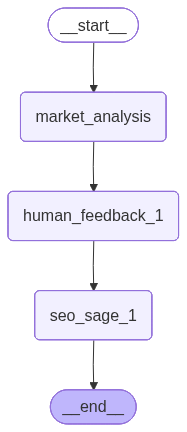

In [ ]:
app

In [ ]:
logger.info("--- Starting Graph Execution (Full App Test) ---")
try:
    # Use a fresh initial state for a full run
    full_run_initial_state = {
        "user_input": user_input_data,
        "human_feedback": None,
        "market_analysis_output": None,
        "seo_sage_output": None,
        "creative_wordsmith_output": None,
        "visual_muse_output": None,
        "campaign_architect_output": None,
        "orchestrator_output": None
    }

    final_state_full_run = app.invoke(full_run_initial_state)

    # Display results from SEO Sage
    seo_output = final_state_full_run["seo_sage_output"]

    print("\n\n========== SEO STRATEGY OUTPUT ==========\n")
    print(f"Strategic Summary: {seo_output.strategic_summary}\n")

    print("--- Keyword Portfolio ---")
    for keyword_data in seo_output.keyword_portfolio:
        print(f"  Keyword: {keyword_data.keyword}, Intent: {keyword_data.intent}, Priority: {keyword_data.priority}, Funnel Stage: {keyword_data.funnel_stage}")
    print("\n")

    print("--- Content Briefs ---")
    for i, brief in enumerate(seo_output.content_briefs):
        print(f"  Brief {i+1}:")
        print(f"    Headline Idea: {brief.headline_idea}")
        print(f"    Primary Keyword: {brief.target_primary_keyword}")
        print(f"    Pain Point Solved: {brief.target_persona_pain_point}")
        print(f"    User Intent: {brief.user_intent}")
        print(f"    Content Format: {brief.content_format}\n")

    print("--- Technical SEO Requirements ---")
    print(f"  URL Structure: {seo_output.technical_requirements.url_structure_recommendation}")
    print(f"  Schema Markup: {', '.join(seo_output.technical_requirements.schema_markup_type)}")
    print(f"  Core Web Vitals Focus: {seo_output.technical_requirements.core_web_vitals_focus}\n")

    print("--- Off-Page Strategy ---")
    print(f"  Backlink Targets: {', '.join(seo_output.off_page_strategy.backlink_targets)}")
    print(f"  PR Angles: {', '.join(seo_output.off_page_strategy.pr_angles)}\n")

    print(f"--- Trend Analysis ---")
    print(f"{seo_output.trend_analysis}")

except Exception as e:
    logger.error(f"Full app execution failed: {e}")

/tmp/ipython-input-2230876134.py:31: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent_executor = create_react_agent(self.llm, research_tools, debug=True)


[values] {'messages': [HumanMessage(content="\nYou are a senior market research analyst.\nYour goal is to gather specific evidence about the product market.\n\nProduct:\n{'product_name': 'AutoContent AI', 'detailed_description': 'An AI-powered platform that generates SEO-optimized blog posts, landing pages, and product descriptions for startups and SMBs.', 'images_videos': None, 'usp': 'High-quality long-form content generated in minutes with minimal editing'}\n\nBusiness context:\n{'target_market_location': 'Europe & North America', 'budget_team_constraints': 'Small marketing team, limited budget, no dedicated content writers', 'brand_voice_tone': 'Professional, data-driven, but friendly'}\n\nMarket goals:\n{'known_competitors': ['Jasper AI', 'Copy.ai'], 'primary_launch_objective': 'Acquire early-stage startup customers and validate product-market fit', 'ideal_customer_hypothesis': 'Startup founders and marketing managers who need content at scale'}\n\nTASKS:\n1. Search for direct com

ERROR:__main__:Full app execution failed: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 12.711878556s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayP